In [2]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 5.9 MB/s eta 0:00:00


In [3]:
# ===================================================================
#   CELL 1: SETUP, SIMULATION, AND RESULT STORAGE (with Controller Warm-up)
# ===================================================================
# This version adds a "warm-up" period to the controller, ignoring model
# predictions for the first second to allow history buffers to fill.
# This prevents initial errors from out-of-distribution inputs.
# ===================================================================

# --- 1. SETUP AND IMPORTS ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import warnings
import torch
from kan import KAN

warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. SYSTEM AND SIMULATION FUNCTIONS --------------------------
def f_slip_ground_truth(state, omega_cmd, kappa, beta):
    _x, _y, _theta, v = state
    return kappa * v * np.tanh(beta * np.abs(omega_cmd))

def robot_step(x_current, u_cmd, h, slip_params):
    kappa, beta = slip_params; _x, _y, theta, v = x_current; omega_cmd, a_cmd = u_cmd
    f_slip = f_slip_ground_truth(x_current, omega_cmd, kappa, beta)
    total_acceleration = a_cmd + f_slip
    rates = np.array([v * np.cos(theta), v * np.sin(theta), omega_cmd, total_acceleration])
    x_new = x_current + h * rates
    return x_new

# --- 3. PATH GENERATION AND CONTROLLER -----------------------------
def generate_figure8_path(num_points=1000, scale=4):
    t = np.linspace(0, 2 * np.pi, num_points); x_ref = scale * np.sin(t); y_ref = scale * np.sin(t) * np.cos(t)
    return np.vstack([x_ref, y_ref]).T

def path_follower_controller(current_state, ref_path, lookahead_dist=0.5):
    x, y, theta, _v = current_state
    distances_sq = (ref_path[:, 0] - x)**2 + (ref_path[:, 1] - y)**2
    closest_idx = np.argmin(distances_sq); lookahead_idx = closest_idx
    while lookahead_idx < len(ref_path) - 1:
        if np.linalg.norm(ref_path[lookahead_idx] - ref_path[closest_idx]) >= lookahead_dist: break
        lookahead_idx += 1
    x_lookahead, y_lookahead = ref_path[lookahead_idx]
    alpha = np.arctan2(y_lookahead - y, x_lookahead - x)
    angle_diff = np.arctan2(np.sin(alpha - theta), np.cos(alpha - theta))
    omega_d = 2.0 * angle_diff
    e_lat = np.sqrt(distances_sq[closest_idx])
    return omega_d, e_lat

# --- 4. MAIN EXECUTION PIPELINE ------------------------------------
def run_all_simulations():
    results = {}; print("--- C1. Data Collection Phase (Temporal Embedding) ---")
    np.random.seed(42); h = 0.02; N_paths = 25; T_path = 40.0; history_len = 3
    X_all, Y_all = [], []
    for i in tqdm(range(N_paths), desc="Generating Data"):
        kappa = 0.15 * (1 + (np.random.rand() - 0.5) * 0.4); beta = 4.0 * (1 + (np.random.rand() - 0.5) * 0.4)
        slip_params = (kappa, beta); x_current = np.zeros(4)
        v_hist = np.zeros(history_len); omega_hist = np.zeros(history_len)
        for k in range(int(T_path / h)):
            t = k * h; omega_cmd = 0.8 * np.sin(0.7 * t + i) + 0.4 * np.sin(1.8*t)
            a_cmd = 0.3 * np.sin(0.4 * t - i) + 0.15 * np.cos(1.3*t)
            true_slip_force = f_slip_ground_truth(x_current, omega_cmd, kappa, beta)
            x_new = robot_step(x_current, [omega_cmd, a_cmd], h, slip_params)
            v_hist = np.roll(v_hist, 1); omega_hist = np.roll(omega_hist, 1)
            v_hist[0] = x_current[3]; omega_hist[0] = omega_cmd
            temporal_input = np.concatenate([v_hist, omega_hist[1:]])
            if k >= history_len - 1:
                X_all.append(temporal_input); Y_all.append(true_slip_force)
            x_current = x_new
    X_all = np.array(X_all); Y_all = np.array(Y_all).reshape(-1, 1)
    scaler_X = StandardScaler(); scaler_Y = StandardScaler()
    Xn = scaler_X.fit_transform(X_all); Yn = scaler_Y.fit_transform(Y_all)
    results['scalers'] = {'X': scaler_X, 'Y': scaler_Y}
    X_tr_n, X_te_n, y_tr_n, y_te_n = train_test_split(Xn, Yn, test_size=0.15, random_state=42)
    X_tr_n, X_va_n, y_tr_n, y_va_n = train_test_split(X_tr_n, y_tr_n, test_size=(0.15/0.85), random_state=42)
    results['test_data'] = {'y_te_n': y_te_n}

    print("\n--- C2. Model Learning Phase ---")
    input_dim = 5; kan = KAN(width=[input_dim, 12, 1], grid=11, k=3, seed=42)
    dataset = {'train_input': torch.from_numpy(X_tr_n).float(), 'train_label': torch.from_numpy(y_tr_n).float(),
               'val_input': torch.from_numpy(X_va_n).float(), 'val_label': torch.from_numpy(y_va_n).float(),
               'test_input': torch.from_numpy(X_te_n).float(), 'test_label': torch.from_numpy(y_te_n).float()}
    print("Training KAN..."); kan.fit(dataset, opt="LBFGS", steps=150, log=25)
    results['kan_model'] = kan

    print("\n--- C3. Symbolic Regression for KAN ---")
    kan.prune(); kan.in_vars = ['v_t', 'v_t_m1', 'v_t_m2', 'w_t_m1', 'w_t_m2']; kan.out_vars = ['f_slip']
    try:
        formula = kan.symbolic_formula()[0]; print(f"\nDiscovered Symbolic Formula:\n  f_slip_norm = {formula}")
        results['kan_formula'] = formula
    except Exception as e:
        print(f"\nCould not generate symbolic formula. Error: {e}"); results['kan_formula'] = "Not found"

    print("\nTraining MLP...")
    MLP_spec = {'hidden_layer_sizes': (8, 8)}
    mlp = MLPRegressor(**MLP_spec, activation='relu', solver='adam', learning_rate_init=3e-3, max_iter=200, batch_size=512, n_iter_no_change=20, random_state=42, early_stopping=True, validation_fraction=(0.15/0.85))
    mlp.fit(X_tr_n, y_tr_n.ravel()); results['mlp_model'] = mlp

    print("\n--- C4. Identification Accuracy (Test Set) ---")
    y_kan_pred_n = kan(dataset['test_input']).detach().numpy(); y_mlp_pred_n = mlp.predict(X_te_n).reshape(-1, 1)
    results['predictions'] = {'kan_n': y_kan_pred_n, 'mlp_n': y_mlp_pred_n}
    mse_kan = mean_squared_error(y_te_n, y_kan_pred_n); r2_kan = r2_score(y_te_n, y_kan_pred_n)
    mse_mlp = mean_squared_error(y_te_n, y_mlp_pred_n); r2_mlp = r2_score(y_te_n, y_mlp_pred_n)
    results['metrics'] = {'kan': {'mse': mse_kan, 'r2': r2_kan}, 'mlp': {'mse': mse_mlp, 'r2': r2_mlp}}
    print(f"{'Model':<6}| {'MSE (Norm.)':<12}| {'R²':<6}"); print("-" * 28)
    print(f"{'KAN':<6}| {mse_kan:<12.4f}| {r2_kan:.4f}"); print(f"{'MLP':<6}| {mse_mlp:<12.4f}| {r2_mlp:.4f}")

    print("\n--- C5. Closed-Loop Evaluation ---")
    T_sim = 40.0; v_d = 0.6; Kp, Ki = 1.0, 0.4; ref_path = generate_figure8_path()
    alpha = 0.7

    # *** NEW: Define a warm-up period in seconds and convert to simulation steps. ***
    warmup_duration = 1.0  # seconds
    warmup_steps = int(warmup_duration / h)

    results['reference_path'] = ref_path; sim_results_cl = {}
    controllers = {'KAN': kan, 'MLP': mlp, 'None': None}
    for name, model in controllers.items():
        print(f"Simulating with {name} compensation...")
        sim_slip_params = (0.15, 4.0); x_current = np.array([-0.4, 0.4, np.deg2rad(25), 0])
        log_X = [x_current]; log_e_lat = []; integral_e_v = 0.0
        v_hist = np.zeros(history_len); omega_hist = np.zeros(history_len)

        for k in tqdm(range(int(T_sim / h)), desc=f"Simulating {name}"):
            omega_d, e_lat = path_follower_controller(x_current, ref_path)
            v_hist = np.roll(v_hist, 1); omega_hist = np.roll(omega_hist, 1)
            v_hist[0] = x_current[3]; omega_hist[0] = omega_d
            temporal_input = np.concatenate([v_hist, omega_hist[1:]]).reshape(1, -1)
            e_v = x_current[3] - v_d; integral_e_v += e_v * h
            a_feedback = -Kp * e_v - Ki * integral_e_v; f_slip_hat = 0.0

            # *** CHANGED: Added warm-up logic. ***
            # Only use the model's prediction *after* the warm-up period.
            if model is not None and k > warmup_steps:
                temporal_input_n = scaler_X.transform(temporal_input)
                if name == 'KAN':
                    state_tensor = torch.from_numpy(temporal_input_n).float()
                    f_slip_hat_n = model(state_tensor).detach().numpy()
                else: f_slip_hat_n = model.predict(temporal_input_n).reshape(-1, 1)
                f_slip_hat = scaler_Y.inverse_transform(f_slip_hat_n)[0, 0]

            a_cmd = a_feedback - alpha * f_slip_hat
            x_new = robot_step(x_current, [omega_d, a_cmd], h, sim_slip_params)
            x_current = x_new
            log_X.append(x_current); log_e_lat.append(e_lat)

        mean_sq_lat_error = np.mean(np.array(log_e_lat)**2); rms_lat_error = np.sqrt(mean_sq_lat_error)
        sim_results_cl[name] = {'trajectory': np.array(log_X), 'rms_error': rms_lat_error, 'mse_error': mean_sq_lat_error}
    results['closed_loop'] = sim_results_cl

    print("\n--- Closed-Loop Path Tracking Performance ---")
    print(f"{'Controller':<25}| {'RMS Lateral Error (m)':<25}| {'MSE Lateral Error (m²)'}")
    print("-" * 75)
    for name, result in sim_results_cl.items():
        print(f"{name + ' Compensation':<25}| {result['rms_error']:<25.4f}| {result['mse_error']:.4f}")

    return results

# --- RUN THE PIPELINE AND STORE RESULTS ---------------------------
simulation_results = run_all_simulations()
print("\n✅ All simulations complete. Results are stored in the 'simulation_results' dictionary.")


--- C1. Data Collection Phase (Temporal Embedding) ---


Generating Data: 100%|██████████| 25/25 [00:02<00:00, 10.14it/s]



--- C2. Model Learning Phase ---
checkpoint directory created: ./model
saving model version 0.0
Training KAN...


| train_loss: 6.02e-02 | test_loss: 6.14e-02 | reg: 0.00e+00 | : 100%|█| 150/150 [54:17<00:00, 21.71


saving model version 0.1

--- C3. Symbolic Regression for KAN ---
saving model version 0.2

Discovered Symbolic Formula:
  f_slip_norm = [0]

Training MLP...

--- C4. Identification Accuracy (Test Set) ---
Model | MSE (Norm.) | R²    
----------------------------
KAN   | 0.0037      | 0.9960
MLP   | 0.0056      | 0.9939

--- C5. Closed-Loop Evaluation ---
Simulating with KAN compensation...


Simulating KAN: 100%|██████████| 2000/2000 [00:31<00:00, 62.50it/s]


Simulating with MLP compensation...


Simulating MLP: 100%|██████████| 2000/2000 [00:01<00:00, 1495.10it/s]


Simulating with None compensation...


Simulating None: 100%|██████████| 2000/2000 [00:00<00:00, 5698.03it/s]


--- Closed-Loop Path Tracking Performance ---
Controller               | RMS Lateral Error (m)    | MSE Lateral Error (m²)
---------------------------------------------------------------------------
KAN Compensation         | 0.0293                   | 0.0009
MLP Compensation         | 0.0286                   | 0.0008
None Compensation        | 0.0306                   | 0.0009

✅ All simulations complete. Results are stored in the 'simulation_results' dictionary.


<>:67: SyntaxWarning: invalid escape sequence '\h'
<>:67: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-965884158.py:67: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('True Slip Force $f_{slip}$'); plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')


Generating Figure 1: Closed-Loop Path Tracking with final inset positions...


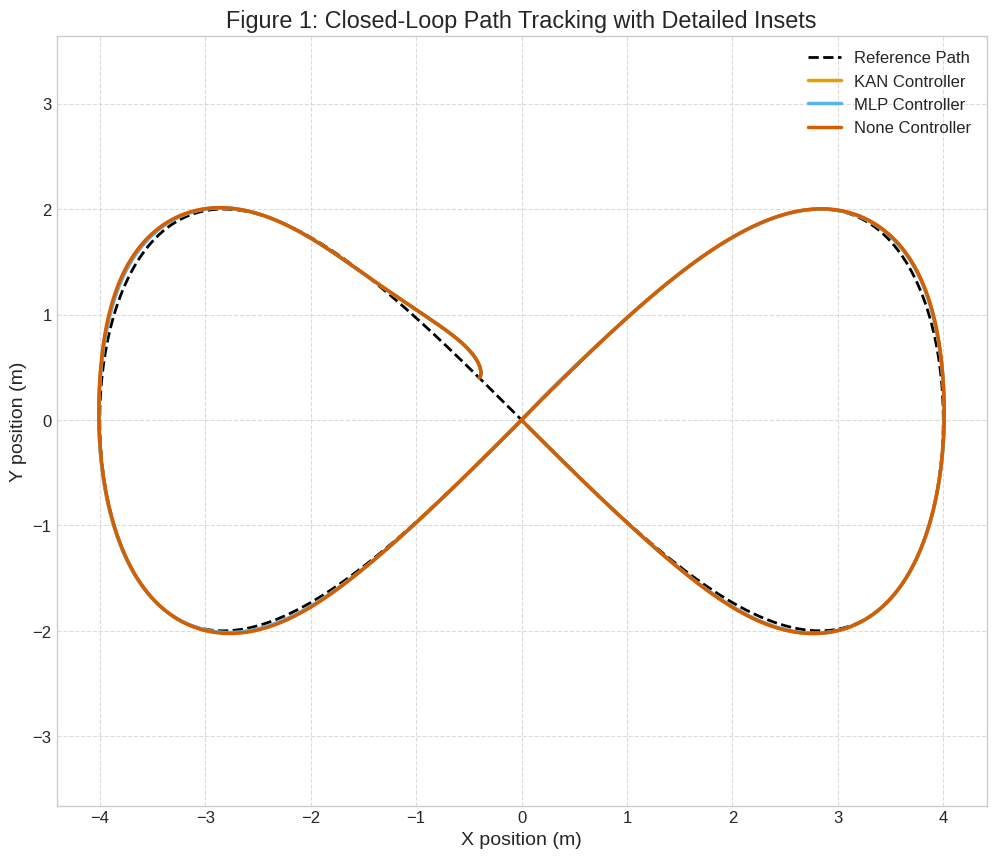


Generating Figure 2: Identification Accuracy...


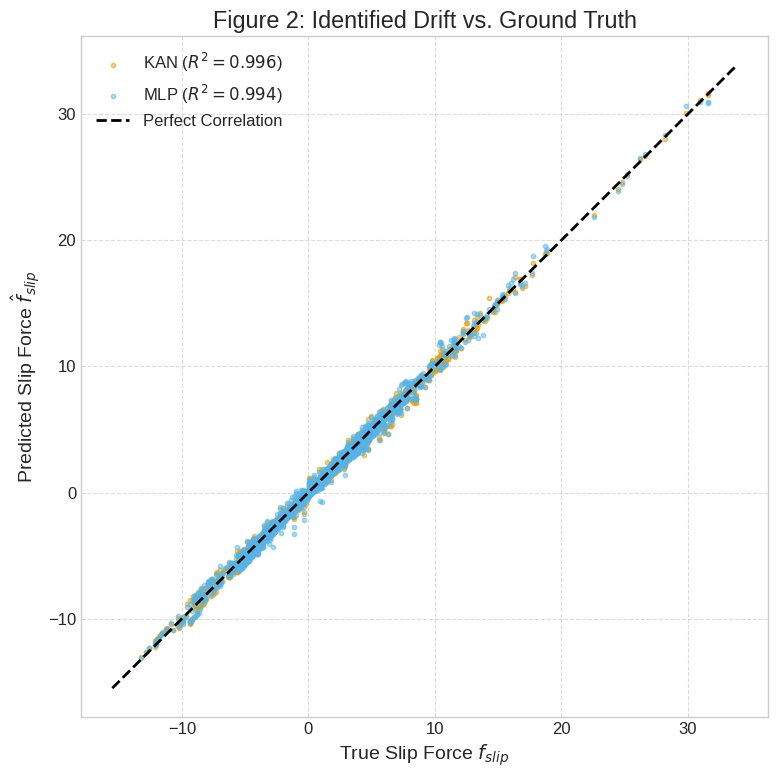

In [4]:
# ===================================================================
#   CELL 2: VISUALIZATION OF RESULTS (Corrected)
# ===================================================================
# This cell has been corrected to properly access the test set's
# ground truth slip values from the new data structure.
# ===================================================================

# --- Import additional tools for zoomed plots ---
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Configure Plot Style ----------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14, 'figure.figsize': (10, 7), 'axes.grid': True,
    'grid.linestyle': '--', 'grid.alpha': 0.7, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'legend.fontsize': 12
})

# --- Unpack results from the dictionary for easier access ---
ref_path_to_plot = simulation_results['reference_path']
closed_loop_results = simulation_results['closed_loop']
metrics = simulation_results['metrics']
predictions = simulation_results['predictions']
test_data = simulation_results['test_data']
scaler_Y = simulation_results['scalers']['Y']
colors = {'KAN': '#E69F00', 'MLP': '#56B4E9', 'None': '#D55E00'}


# --- Plot 1: Closed-Loop Path Tracking Comparison with Final Inset Positions ---
print("Generating Figure 1: Closed-Loop Path Tracking with final inset positions...")
fig, ax = plt.subplots(figsize=(12, 10))

# Plot main trajectories on the main axes
ax.plot(ref_path_to_plot[:, 0], ref_path_to_plot[:, 1], 'k--', lw=2, label='Reference Path')
for name, result in closed_loop_results.items():
    traj = result['trajectory']
    ax.plot(traj[:, 0], traj[:, 1], label=f'{name} Controller', color=colors[name], lw=2.5)


# Finalize the main plot
ax.set_title('Figure 1: Closed-Loop Path Tracking with Detailed Insets')
ax.set_xlabel('X position (m)'); ax.set_ylabel('Y position (m)')
ax.legend(); ax.axis('equal'); ax.grid(True)
plt.show()


# --- Plot 2: Identification Accuracy (Predicted vs. True) ---
print("\nGenerating Figure 2: Identification Accuracy...")
# Un-normalize predictions and true values for plotting
y_kan_pred = scaler_Y.inverse_transform(predictions['kan_n'])
y_mlp_pred = scaler_Y.inverse_transform(predictions['mlp_n'])

# *** CORRECTED LINE: Get true values from the test labels and un-normalize them. ***
f_slip_te_true = scaler_Y.inverse_transform(test_data['y_te_n'])

r2_kan = metrics['kan']['r2']
r2_mlp = metrics['mlp']['r2']
plt.figure(figsize=(8, 8))
plt.scatter(f_slip_te_true, y_kan_pred, alpha=0.5, s=10,
            label=f'KAN ($R^2={r2_kan:.3f}$)', color='#E69F00')
plt.scatter(f_slip_te_true, y_mlp_pred, alpha=0.5, s=10,
            label=f'MLP ($R^2={r2_mlp:.3f}$)', color='#56B4E9')

lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', lw=2, label='Perfect Correlation')
plt.title('Figure 2: Identified Drift vs. Ground Truth')
plt.xlabel('True Slip Force $f_{slip}$'); plt.ylabel('Predicted Slip Force $\hat{f}_{slip}$')
plt.legend(); plt.axis('equal'); plt.grid(True)
plt.tight_layout(); plt.show()

In [5]:
# ===================================================================
#   CELL 3: Calculate and Display Tracking MSE from Stored Results
# ===================================================================
# This cell uses the RMS error stored in the `simulation_results`
# dictionary to calculate and display the Mean Squared Error (MSE).
# ===================================================================

print("\n--- Closed-Loop Path Tracking Performance (MSE Calculation) ---")
print(f"{'Controller':<25}| {'RMS Lateral Error (m)':<25}| {'MSE Lateral Error (m²)'}")
print("-" * 75)

# Access the results generated by Cell 1
closed_loop_results = simulation_results['closed_loop']

# Iterate through each controller's results
for name, result in closed_loop_results.items():
    # Retrieve the already calculated RMS error
    rms_error = result['rms_error']

    # Calculate MSE directly from RMS error (since MSE = RMS^2)
    mse_error = rms_error ** 2

    # (Optional but good practice) Add the calculated MSE back into the results dictionary
    result['mse_error'] = mse_error

    # Print the formatted output including the new MSE value
    print(f"{name + ' Compensation':<25}| {rms_error:<25.4f}| {mse_error:.4f}")


--- Closed-Loop Path Tracking Performance (MSE Calculation) ---
Controller               | RMS Lateral Error (m)    | MSE Lateral Error (m²)
---------------------------------------------------------------------------
KAN Compensation         | 0.0293                   | 0.0009
MLP Compensation         | 0.0286                   | 0.0008
None Compensation        | 0.0306                   | 0.0009


Generating the simulation plot for KAN vs. Reference Path...


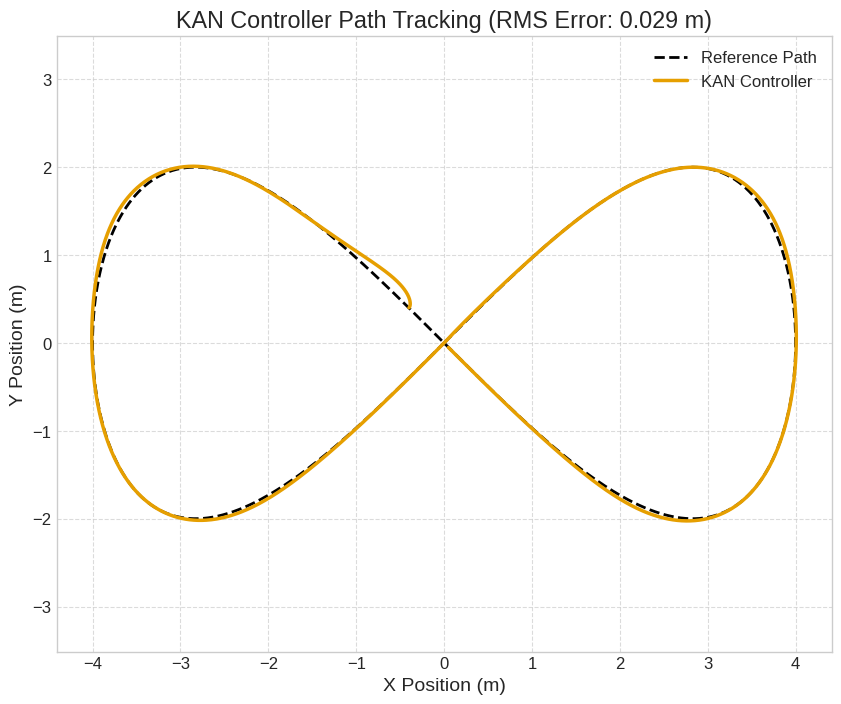

In [6]:
# ===================================================================
#   CELL 4: VISUALIZE KAN PATH TRACKING PERFORMANCE
# ===================================================================
# This cell uses the 'simulation_results' from Cell 1 to plot
# the closed-loop path tracking for the KAN controller only.
# ===================================================================

# --- 1. Configure Plot Style ----------------------------------------
# Use a consistent and clean style for the plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 14,
    'figure.figsize': (10, 8),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# --- 2. Unpack Necessary Data from Results -------------------------
# Extract the reference path and the KAN controller's trajectory
ref_path_to_plot = simulation_results['reference_path']
kan_closed_loop_result = simulation_results['closed_loop']['KAN']
kan_trajectory = kan_closed_loop_result['trajectory']
kan_rms_error = kan_closed_loop_result['rms_error']

# --- 3. Generate the Plot ------------------------------------------
print("Generating the simulation plot for KAN vs. Reference Path...")
fig, ax = plt.subplots()

# Plot the target reference path (black dashed line)
ax.plot(ref_path_to_plot[:, 0], ref_path_to_plot[:, 1], 'k--', lw=2, label='Reference Path')

# Plot the actual path taken by the KAN-controlled robot (orange line)
ax.plot(kan_trajectory[:, 0], kan_trajectory[:, 1], color='#E69F00', lw=2.5, label='KAN Controller')

# --- 4. Finalize the Plot ------------------------------------------
# Add title, labels, and legend for clarity
ax.set_title(f'KAN Controller Path Tracking (RMS Error: {kan_rms_error:.3f} m)')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.legend()
ax.axis('equal') # This is crucial for correctly visualizing path geometry
ax.grid(True)

# Show the final plot
plt.show()